# Linear Workbook
By Tanay Trivedi and Jonathan Bair

# Imports and Formatting

In [5]:
import numpy as np
import pandas as pd

In [6]:
data=pd.read_hdf('full_data.hdf')

In [7]:
data=data.dropna()

In [8]:
data['response']=data['fx'].pct_change()

In [9]:
data['response']=data['response'].shift(-1)

In [10]:
X=data.copy()
del X['fx']
del X['response']
y=data['response'].copy()


In [11]:
newX=pd.DataFrame()
newX['diff_inf']=X['jad_inf']-X['usd_inf']
newX['diff_tbill']=X['jad_tbill']-X['usd_tbill']
newX["diff_oir"]=X["jad_oir"]-X["usd_oir"]
newX["tourism"]=X['tourism']

In [12]:
newX=newX.pct_change()

In [13]:
newX=newX.iloc[1:]

In [14]:
newX["intercept"]=1

In [15]:
y=y.iloc[1:]

In [16]:
train_X=newX.iloc[:int(0.8*len(newX))]
val_X=newX.iloc[int(0.8*len(newX)):int(0.9*len(newX))]
test_X=newX.iloc[int(0.9*len(newX)):]

train_y=y.iloc[:int(0.8*len(y))]
val_y=y.iloc[int(0.8*len(y)):int(0.9*len(y))]
test_y=y.iloc[int(0.9*len(y)):]

In [17]:
test_X=test_X.iloc[:-1]
test_y=test_y.iloc[:-1]

In [18]:
len(train_X)

103

In [19]:
len(train_y)

103

# Scaling

In [20]:
with pd.option_context('mode.use_inf_as_null', True):
    train_X = train_X.dropna()
    train_y=train_y.loc[train_X.index]

In [21]:
len(train_X)

102

In [22]:
features=list(train_X.columns)

In [23]:
features

['diff_inf', 'diff_tbill', 'diff_oir', 'tourism', 'intercept']

In [24]:
features=features[:-1]

In [25]:
features

['diff_inf', 'diff_tbill', 'diff_oir', 'tourism']

In [26]:
mus=train_X[features].mean().to_dict()

In [27]:
mus

{'diff_inf': 0.0025794448862713803,
 'diff_oir': -0.0039218389843883135,
 'diff_tbill': -0.0020261457034433665,
 'tourism': 0.1086817350456867}

In [28]:
sigmas=train_X[features].std().to_dict()

In [29]:
sigmas

{'diff_inf': 2.523251535718829,
 'diff_oir': 0.05796874158309547,
 'diff_tbill': 0.10984407086814305,
 'tourism': 0.998048225755341}

In [30]:
train_X[features]=(train_X[features]-mus)/sigmas
val_X[features]=(val_X[features]-mus)/sigmas
test_X[features]=(test_X[features]-mus)/sigmas

/home/meltingpot/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [31]:
mus=train_y.mean()
sigmas=train_y.std()
train_y=(train_y-mus)/sigmas
val_y=(val_y-mus)/sigmas
test_y=(test_y-mus)/sigmas

# Linear Regression

In [32]:
X_mat=train_X.values

In [33]:
from numpy.linalg import inv

In [34]:
beta_hat=np.matmul(np.matmul(inv(np.matmul(X_mat.T,X_mat)),X_mat.T),train_y.values)

In [35]:
beta_hat

array([  8.26093063e-03,   3.30132398e-01,   1.66805327e-01,
        -8.21329001e-03,  -1.21430643e-17])

In [36]:
y_hat=np.matmul(test_X.values,beta_hat)

In [37]:
mse=np.mean(np.power(test_y.values-y_hat,2))

In [38]:
mse

0.096862851855098797

In [39]:
%matplotlib inline

In [40]:
import matplotlib.pyplot as plt

In [41]:
y_lin=pd.DataFrame()
y_lin['y']=test_y
y_lin['yhat']=y_hat

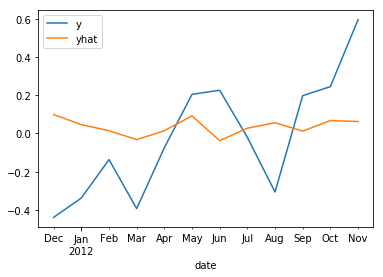

In [42]:
y_lin.plot()

In [43]:
y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])

In [44]:
len(y_lin[y_lin['sign']==True])/float(len(y_lin))

0.4166666666666667

# Ridge

In [70]:
def ridge_solve(train_X,train_y,lambd):
    return np.matmul(np.matmul(inv(np.matmul(train_X.T,train_X)+lambd*np.ones((train_X.shape[1],1))),train_X.T),train_y)

In [71]:
beta_hat=[]
for i in np.arange(0.1,1,0.1):
    beta_hat.append(ridge_solve(train_X,train_y,i))

In [72]:
len(beta_hat)

9

In [73]:
error=pd.DataFrame(index=np.arange(0.1,1,0.1),columns=["mse","acc"])
ix=0.1
for i in range(len(beta_hat)):
    y_hat=np.matmul(val_X.values,beta_hat[i])
    mse=np.mean(np.power(val_y.values-y_hat,2))
    error.iloc[i]["mse"]=mse
    
    y_lin=pd.DataFrame()
    y_lin['y']=val_y
    y_lin['yhat']=y_hat
    
    y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])
    error.iloc[i]["acc"]=len(y_lin[y_lin['sign']==True])/float(len(y_lin))

In [74]:
error

,mse,acc
0.1,0.137659,0.538462
0.2,0.137406,0.538462
0.3,0.137156,0.538462
0.4,0.136908,0.538462
0.5,0.136663,0.538462
0.6,0.13642,0.538462
0.7,0.13618,0.538462
0.8,0.135942,0.538462
0.9,0.135707,0.538462


Sign Accuracy is the same for all, we should just pick by MSE.

In [75]:
np.argmin(error["mse"].values)

8

In [76]:
error.index[np.argmin(error["mse"].values)]

0.90000000000000002

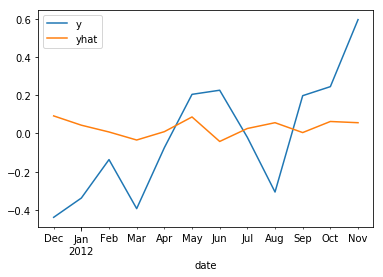

In [77]:
y_hat=np.matmul(test_X.values,beta_hat[-1])

y_lin=pd.DataFrame()
y_lin['y']=test_y
y_lin['yhat']=y_hat

y_lin.plot()

In [78]:
mse=np.mean(np.power(test_y.values-y_hat,2))

In [79]:
mse

0.096904667717962703

In [80]:
y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])
len(y_lin[y_lin['sign']==True])/float(len(y_lin))

0.4166666666666667

# Lasso

In [56]:
from sklearn.linear_model import Lasso

In [57]:
def lasso_solve(train_X,train_y,alpha):
    lassoreg = Lasso(alpha=alpha, normalize = True )
    lassoreg.fit(train_X.values[:,:-1],train_y)
    return np.append(lassoreg.coef_,lassoreg.intercept_)

In [58]:
alpha_lasso = [1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2, 1, 5, 10]

In [59]:
beta_hat=[]
for i in alpha_lasso:
    beta_hat.append(lasso_solve(train_X,train_y,i))

In [60]:
error=pd.DataFrame(index=alpha_lasso,columns=["mse","acc"])
for i in range(len(beta_hat)):
    y_hat=np.matmul(val_X.values,beta_hat[i])
    mse=np.mean(np.power(val_y.values-y_hat,2))
    error.iloc[i]["mse"]=mse
    
    y_lin=pd.DataFrame()
    y_lin['y']=val_y
    y_lin['yhat']=y_hat
    
    y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])
    error.iloc[i]["acc"]=len(y_lin[y_lin['sign']==True])/float(len(y_lin))

In [61]:
error

,mse,acc
1.000000e-15,0.137914,0.538462
1.000000e-10,0.137914,0.538462
1.000000e-08,0.137914,0.538462
1.000000e-05,0.137916,0.538462
1.000000e-04,0.137938,0.538462
1.000000e-03,0.138051,0.538462
1.000000e-02,0.138842,0.538462
1.000000e+00,0.164545,1
5.000000e+00,0.164545,1
1.000000e+01,0.164545,1


Sign accuracy is skewed here from the fact that the val set is all negative numbers. Ignore for now.

In [62]:
np.argmin(error["mse"].values)

2

In [63]:
error.index[np.argmin(error["mse"].values)]

1e-08

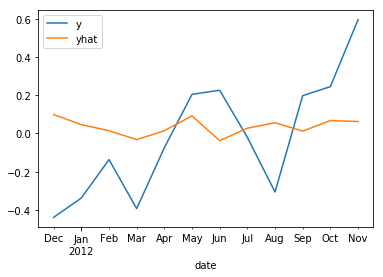

In [64]:
y_hat=np.matmul(test_X.values,beta_hat[np.argmin(error["mse"].values)])

y_lin=pd.DataFrame()
y_lin['y']=test_y
y_lin['yhat']=y_hat

y_lin.plot()

In [65]:
y_lin

,y,yhat
date,,
2011-12-01,-0.439221,0.098026
2012-01-01,-0.338465,0.045543
2012-02-01,-0.137423,0.013509
2012-03-01,-0.393778,-0.032813
2012-04-01,-0.075246,0.013365
2012-05-01,0.203748,0.091349
2012-06-01,0.225244,-0.038672
2012-07-01,-0.021075,0.026884
2012-08-01,-0.306944,0.055284


In [67]:
mse=np.mean(np.power(test_y.values-y_hat,2))
mse

0.096862849277366492

In [68]:
y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])
len(y_lin[y_lin['sign']==True])/float(len(y_lin))

0.4166666666666667

# Final Results

In [97]:
results=pd.DataFrame(columns=['mse','sign_acc'],index=['Least Squares','Ridge','Lasso'])

In [81]:
beta_hat_ls=np.matmul(np.matmul(inv(np.matmul(X_mat.T,X_mat)),X_mat.T),train_y.values)
beta_hat_ridge=ridge_solve(train_X,train_y,0.9)
beta_hat_lasso=lasso_solve(train_X,train_y,1e-08)

In [99]:
beta_hats=[beta_hat_ls,beta_hat_ridge,beta_hat_lasso]
for i in range(len(beta_hats)):
    y_hat=np.matmul(test_X.values,beta_hats[i])
    mse=np.mean(np.power(test_y.values-y_hat,2))
    results.iloc[i]["mse"]=mse
    
    y_lin=pd.DataFrame()
    y_lin['y']=test_y
    y_lin['yhat']=y_hat
    
    y_lin['sign']=np.sign(y_lin["y"])==np.sign(y_lin["yhat"])
    results.iloc[i]["sign_acc"]=len(y_lin[y_lin['sign']==True])/float(len(y_lin))

In [100]:
results

,mse,sign_acc
Least Squares,0.0968629,0.416667
Ridge,0.0969047,0.416667
Lasso,0.0968628,0.416667


Lasso just eked out ahead.